In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [ ]:
labels_pd = pd.read_csv("/content/drive/My Drive/245/final project/labels.csv")
counts_pd = pd.read_csv("/content/drive/My Drive/245/final project/processed_counts.csv")

In [ ]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [ ]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
    cell_type = df.iloc[i]['bulk_labels']
    pos = np.where(categories == cell_type)[0]
    y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


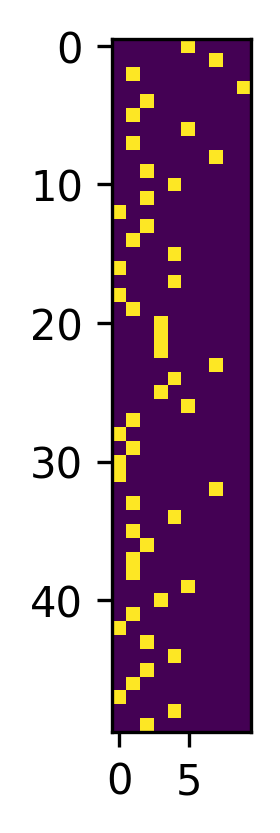

In [ ]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

Try out a few different classifiers, and experiment with different parameters! You can use decision trees, random forests, logistic regressions, KNNs, feedforward neural networks, etc. You can also try applying ensemble methods such as bagging and boosting to these classifiers.

You can also apply classification downstream of last week's autoencoder latent space representation.

A good target accuracy to aim for is at least 80% on the test set (but there is no strict grading cutoff for accuracy).

In [ ]:
# Decision trees: https://scikit-learn.org/stable/modules/tree.html
# Ensemble methods: https://scikit-learn.org/stable/modules/ensemble.html


In [ ]:
# FFNN hints: 
# Use softmax at the end, reLU for the rest
# Add layers until desired loss
# Categorical cross-entropy for loss func
# Add dropout layers to avoid overfitting
# Can also implement bagging for FFNNs (but probably not necessary)


In [ ]:
# Cross-validation: https://scikit-learn.org/stable/modules/cross_validation.html
#(recommended for decision trees/random forests)
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(clf, X, y, cv=5)
# where: 
# clf -> classifier object
# cv -> number of folds of cross-validation (can also pass output of ShuffleSplit)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

#### Get original label of y

In [ ]:
y_train_back = np.argmax(y_train, axis=1)
y_test_back = np.argmax(y_test, axis=1)

### cross_val_score
cross_val_score returns an array of scores, one for each fold in the cross-validation. These scores can be used to estimate the classifier's performance and its generalization ability on unseen data. You can calculate the **mean and standard deviation** of these scores to get a summary of the model's performance.

## RandomForest

In [ ]:
# Using corss_val_score to find the best numbers of tree
rfc = RandomForestClassifier()
n_estimators_range = np.arange(10,200,10)

rfc_mean_score = []
rfc_std_score = [] # in case the std is too large

for n_tree in n_estimators_range:
  rfc = RandomForestClassifier(n_tree)
  score = cross_val_score(rfc, X_train, y_train_back, cv=5, scoring='accuracy')
  mean, std = np.mean(score), np.std(score)
  rfc_mean_score.append(mean)
  rfc_std_score.append(std)

best_n_estimators = n_estimators_range[np.argmax(rfc_mean_score)]
score_of_best = rfc_mean_score[np.argmax(rfc_mean_score)]
std_of_best = rfc_std_score[np.argmax(rfc_mean_score)]
print(f"Best number of trees (n_estimators): {best_n_estimators} with the mean score of {score_of_best} and std of: {std_of_best}")

Best number of trees (n_estimators): 130 with the mean score of 0.8125 and std of: 0.036157958448779615


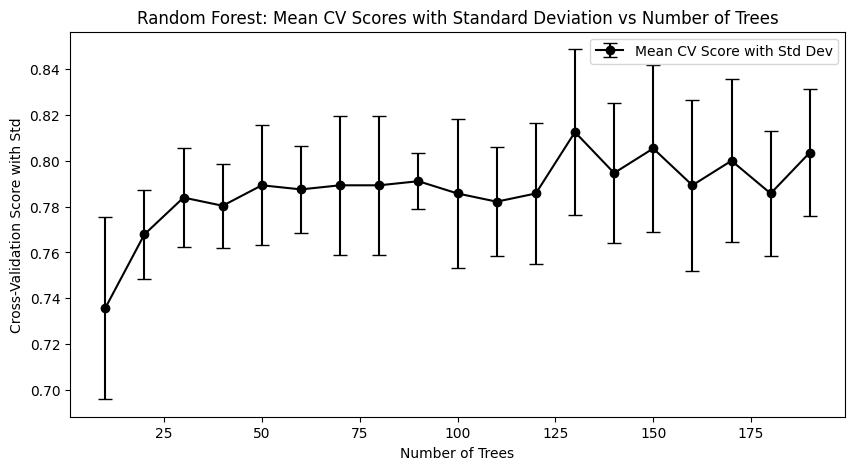

In [ ]:
# plot the mean and std
plt.figure(figsize=(10,5))
plt.errorbar(n_estimators_range, rfc_mean_score, yerr=rfc_std_score, fmt='-o',
             color='black', capsize=5, label='Mean CV Score with Std Dev')
plt.xlabel("Number of Trees")
plt.ylabel("Cross-Validation Score with Std")
plt.legend()
plt.title("Random Forest: Mean CV Scores with Standard Deviation vs Number of Trees")
plt.show()

In [ ]:
# obtain accuracy of test set using training rfc
rfc = RandomForestClassifier(best_n_estimators)
rfc.fit(X_train, y_train_back)
pred_test = rfc.predict(X_test)
accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy is ", accuracy)
print(classification_report(pred_test, y_test_back))

accuracy is  0.8
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        34
           1       0.86      0.86      0.86        50
           2       0.83      0.83      0.83         6
           3       0.90      0.60      0.72        15
           4       1.00      0.94      0.97        16
           5       0.57      0.67      0.62        12
           6       0.00      0.00      0.00         0
           7       0.56      0.83      0.67         6
           8       0.00      0.00      0.00         0
           9       0.33      1.00      0.50         1

    accuracy                           0.80       140
   macro avg       0.59      0.65      0.60       140
weighted avg       0.84      0.80      0.81       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# using grid search
param_grid = {'n_estimators': [50, 75, 100, 125, 150],
    'max_depth': [None,10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],}
# initialize another rfc model for grid search
rfc_grid = RandomForestClassifier()
# initialize grid seach for rfc
grid_search_rfc = GridSearchCV(estimator=rfc_grid, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
grid_search_rfc.fit(X_train, y_train_back)
best_params = grid_search_rfc.best_params_
print(f"Best hyperparameters: {best_params}")
best_rfc = grid_search_rfc.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
# obtain accuracy of test set using training rfc
best_rfc.fit(X_train, y_train_back)
pred_test = best_rfc.predict(X_test)
# rfc_grid_best = RandomForestClassifier(n_estimators=125, max_depth=40, min_samples_split=5, min_samples_leaf=1)
# rfc_grid_best.fit(X_train, y_train_back)
# pred_test = rfc_grid_best.predict(X_test)
accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy is ", accuracy)
print(classification_report(pred_test, y_test_back))

accuracy is  0.8214285714285714
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        36
           1       0.86      0.90      0.88        48
           2       0.67      0.80      0.73         5
           3       1.00      0.67      0.80        15
           4       1.00      1.00      1.00        15
           5       0.64      0.64      0.64        14
           6       0.00      0.00      0.00         0
           7       0.56      1.00      0.71         5
           8       0.00      0.00      0.00         0
           9       0.67      1.00      0.80         2

    accuracy                           0.82       140
   macro avg       0.63      0.68      0.64       140
weighted avg       0.86      0.82      0.83       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# cross_val_score
#dt = DecisionTreeClassifier()
max_depth_range = np.arange(1,20,2)

dt_mean_score = []
dt_std_score = [] # in case the std is too large

for depth in max_depth_range:
  dt = DecisionTreeClassifier(max_depth=depth)
  score = cross_val_score(dt, X_train, y_train_back, cv=5, scoring='accuracy', error_score='raise')
  mean, std = np.mean(score), np.std(score)
  dt_mean_score.append(mean)
  dt_std_score.append(std)


In [ ]:

best_depth = max_depth_range[np.argmax(dt_mean_score)]
score_of_best = dt_mean_score[np.argmax(dt_mean_score)]
std_of_best = dt_std_score[np.argmax(dt_mean_score)]
print(f"Best max depth: {best_depth} with the mean score of {score_of_best} and std of: {std_of_best}")

Best max depth: 5 with the mean score of 0.7303571428571428 and std of: 0.05369034420847469


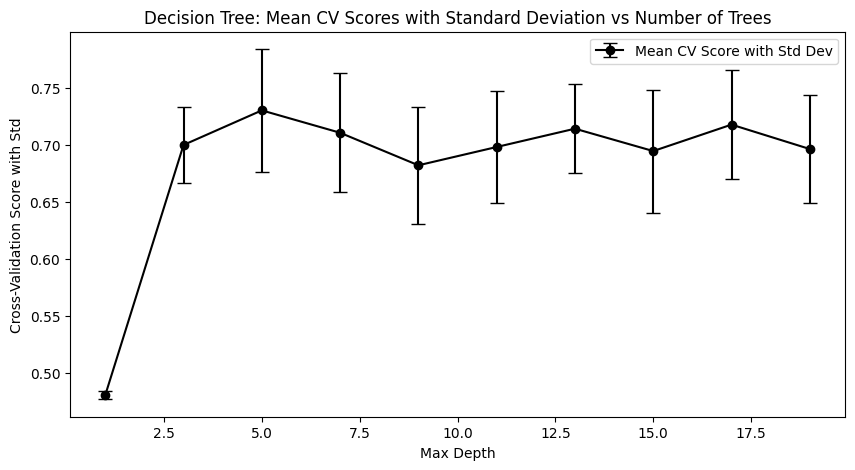

In [ ]:
# plot the mean and std
plt.figure(figsize=(10,5))
plt.errorbar(max_depth_range, dt_mean_score, yerr=dt_std_score, fmt='-o',
             color='black', capsize=5, label='Mean CV Score with Std Dev')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validation Score with Std")
plt.legend()
plt.title("Decision Tree: Mean CV Scores with Standard Deviation vs Number of Trees")
plt.show()

In [ ]:
# obtain accuracy of test set using training rfc
dt = DecisionTreeClassifier(max_depth=best_depth) 
dt.fit(X_train, y_train_back)
pred_test = dt.predict(X_test)
accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy is ", accuracy)
print(classification_report(pred_test, y_test_back))

accuracy is  0.6928571428571428
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        27
           1       0.86      0.78      0.82        55
           2       0.67      0.67      0.67         6
           3       0.90      0.53      0.67        17
           4       0.80      0.92      0.86        13
           5       0.43      0.46      0.44        13
           6       0.00      0.00      0.00         0
           7       0.33      0.50      0.40         6
           8       0.00      0.00      0.00         0
           9       0.33      0.33      0.33         3

    accuracy                           0.69       140
   macro avg       0.50      0.49      0.49       140
weighted avg       0.73      0.69      0.71       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# using grid search
param_grid = {
    'max_depth': [None,2, 4, 6, 8],
    'min_samples_split': [1, 2, 5, 7,10],
    'min_samples_leaf': [1, 2, 4, 6, 8],}
# initialize another rfc model for grid search
dt_grid = DecisionTreeClassifier()
# initialize grid seach for rfc
grid_search_dt = GridSearchCV(estimator=dt_grid, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
grid_search_dt.fit(X_train, y_train_back)
best_params = grid_search_dt.best_params_
print(f"Best hyperparameters: {best_params}")
best_dt = grid_search_dt.best_estimator_

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best hyperparameters: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 2}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
125 fits failed out of a total of 625.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _vali

In [ ]:
# obtain accuracy of test set using training dt
best_dt.fit(X_train, y_train_back)
pred_test = best_dt.predict(X_test)
accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy of decision tree classifier is ", accuracy)
print(classification_report(pred_test, y_test_back))

accuracy of decision tree classifier is  0.7357142857142858
              precision    recall  f1-score   support

           0       0.67      0.77      0.71        26
           1       0.90      0.79      0.84        57
           2       0.67      0.67      0.67         6
           3       0.70      0.50      0.58        14
           4       0.87      0.93      0.90        14
           5       0.50      0.78      0.61         9
           6       0.00      0.00      0.00         2
           7       0.67      0.60      0.63        10
           8       0.00      0.00      0.00         0
           9       0.33      0.50      0.40         2

    accuracy                           0.74       140
   macro avg       0.53      0.55      0.53       140
weighted avg       0.76      0.74      0.74       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## AdaBoost

In [ ]:

from sklearn.ensemble import AdaBoostClassifier
# cross_val_score
#dt = DecisionTreeClassifier()
n_estimators_range = np.arange(10,200,10)

clf_mean_score = []
clf_std_score = [] # in case the std is too large

for n in n_estimators_range:
  clf = AdaBoostClassifier(n_estimators=n)
  score = cross_val_score(clf, X_train, y_train_back, cv=5, scoring='accuracy')
  mean, std = np.mean(score), np.std(score)
  clf_mean_score.append(mean)
  clf_std_score.append(std)

In [ ]:
n_estimators_range[np.argmax(clf_mean_score)]

20

In [ ]:
best_n_estimators = n_estimators_range[np.argmax(clf_mean_score)]
score_of_best = clf_mean_score[np.argmax(clf_mean_score)]
std_of_best = clf_std_score[np.argmax(clf_mean_score)]
print(f"Best number of trees (n_estimators): {best_n_estimators} with the mean score of {score_of_best} and std of: {std_of_best}")

Best number of trees (n_estimators): 20 with the mean score of 0.36607142857142855 and std of: 0.14951025492096057


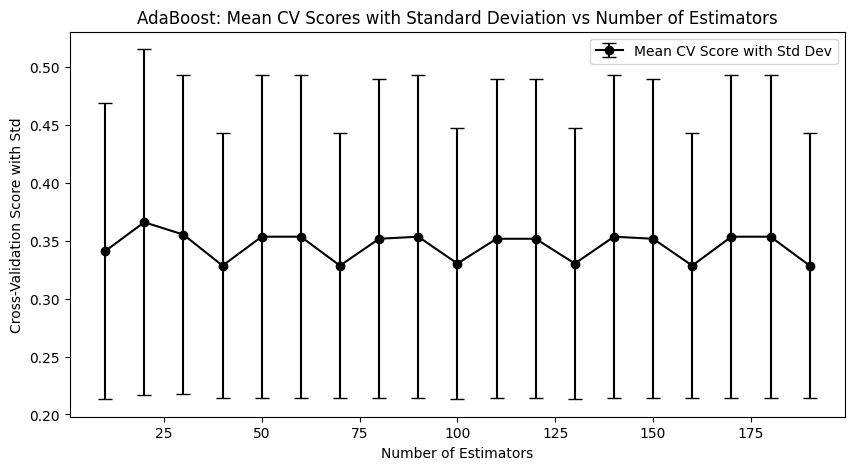

In [ ]:
# plot the mean and std
plt.figure(figsize=(10,5))
plt.errorbar(n_estimators_range, clf_mean_score, yerr=clf_std_score, fmt='-o',
             color='black', capsize=5, label='Mean CV Score with Std Dev')
plt.xlabel("Number of Estimators")
plt.ylabel("Cross-Validation Score with Std")
plt.legend()
plt.title("AdaBoost: Mean CV Scores with Standard Deviation vs Number of Estimators")
plt.show()

In [ ]:
# obtain accuracy of test set using training rfc
clf = DecisionTreeClassifier(max_depth=best_depth) 
clf.fit(X_train, y_train_back)
pred_test = clf.predict(X_test)
accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy is ", accuracy)
print(classification_report(pred_test, y_test_back))

accuracy is  0.7
              precision    recall  f1-score   support

           0       0.60      0.69      0.64        26
           1       0.86      0.77      0.81        56
           2       0.67      0.80      0.73         5
           3       0.90      0.56      0.69        16
           4       0.87      0.93      0.90        14
           5       0.50      0.50      0.50        14
           6       0.00      0.00      0.00         1
           7       0.33      0.50      0.40         6
           8       0.00      0.00      0.00         0
           9       0.33      0.50      0.40         2

    accuracy                           0.70       140
   macro avg       0.51      0.53      0.51       140
weighted avg       0.74      0.70      0.71       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
base_classifier = DecisionTreeClassifier(max_depth=5)
ada_clf = AdaBoostClassifier(base_estimator=base_classifier)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.005, 0.01, 0.1],
    'algorithm': ['SAMME', 'SAMME.R']
}

grid_search_ada = GridSearchCV(ada_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
grid_search_ada.fit(X_train, y_train_back)
best_ada_params = grid_search_ada.best_params_
print(f"Best hyperparameters: {best_ada_params}")
best_ada_clf = grid_search_ada.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best hyperparameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
# obtain accuracy of test set using training dt
best_ada_clf.fit(X_train, y_train_back)
pred_test = best_ada_clf.predict(X_test)
accuracy = accuracy_score(pred_test, y_test_back)\

print("accuracy of AdaBoost classifier is ", accuracy)
print(classification_report(pred_test, y_test_back))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


accuracy of AdaBoost classifier is  0.7857142857142857
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        34
           1       0.86      0.88      0.87        49
           2       0.67      0.80      0.73         5
           3       1.00      0.50      0.67        20
           4       0.93      1.00      0.97        14
           5       0.50      0.58      0.54        12
           6       0.00      0.00      0.00         0
           7       0.44      1.00      0.62         4
           8       0.00      0.00      0.00         0
           9       0.67      1.00      0.80         2

    accuracy                           0.79       140
   macro avg       0.59      0.65      0.60       140
weighted avg       0.84      0.79      0.79       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Support Vector Machine (SVM) classifier

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto',1, 0.1, 0.01, 0.001]
}

grid_search_svc = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svc.fit(X_train, y_train_back)

best_svc_params = grid_search_svc.best_params_
print(f"Best hyperparameters: {best_svc_params}")
best_svc = grid_search_svc.best_estimator_


Best hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
# obtain accuracy of test set using training dt
best_svc.fit(X_train, y_train_back)
pred_test = best_svc.predict(X_test)
accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy of decision tree classifier is ", accuracy)
print(classification_report(pred_test, y_test_back))

accuracy of decision tree classifier is  0.8428571428571429
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        34
           1       0.90      0.92      0.91        49
           2       0.83      1.00      0.91         5
           3       1.00      0.56      0.71        18
           4       0.87      1.00      0.93        13
           5       0.64      0.75      0.69        12
           6       0.00      0.00      0.00         0
           7       0.78      1.00      0.88         7
           8       0.00      0.00      0.00         0
           9       0.67      1.00      0.80         2

    accuracy                           0.84       140
   macro avg       0.66      0.70      0.67       140
weighted avg       0.88      0.84      0.85       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## FFNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

from copy import deepcopy

In [ ]:
X_train_t, y_train_back_t = torch.tensor(X_train).type(torch.float32), torch.tensor(y_train_back).type(torch.long)
X_test_t, y_test_back_t = torch.tensor(X_test).type(torch.float32), torch.tensor(y_test_back).type(torch.long)

In [ ]:
class My_Network(nn.Module):
    def __init__(self, num_layers, hidden_size):
        super().__init__()
        input_dim = 765
        output_dim = 10
        drop_rate = 0.5
        #mid_dim = int(hidden_size * drop_rate)

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_dim, hidden_size)
        
        self.hidden_layer_list = nn.ModuleList() #generate a list of hidden layer with different weight and bias
        self.batch_norm_list = nn.ModuleList()
        for i in range(num_layers):
          self.hidden_layer_list.append(nn.Linear(hidden_size, hidden_size))
          self.batch_norm_list.append(nn.BatchNorm1d(hidden_size))
        self.batch_norm = nn.BatchNorm1d(hidden_size) #Lu: remember dropout layer don't change the shape of hidden layer
        self.drop_layer = nn.Dropout(drop_rate) # 50% probability 
       
        #self.hidden_layer_mid = nn.Linear(mid_dim, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_dim)
    
    def forward(self, X):
        X = self.input_layer(X)
        
        X = self.batch_norm(X)
        X = F.relu(X)
        for hidden_layer, batch_norm in zip(self.hidden_layer_list, self.batch_norm_list):
          
          X = hidden_layer(X)
          
          X = batch_norm(X)
          X = F.relu(X)
          X = self.drop_layer(X)
        logits = self.output_layer(X) 
        return logits
    def classify(self, X):
        X = torch.clone(X).type(torch.float32)
        logits = self.forward(X) # calculate theta after NN forward (define by my self)
        soft_prob = F.softmax(logits, dim=1)
        labels = torch.argmax(soft_prob, dim=1)
        return labels

In [ ]:
def train(model, X_train, y_train, X_val, y_val, epochs=15, batch_size=32, lr=1e-3):
    
    best_acc = -1
    best_model = None
    batches = len(X_train)//batch_size   # using batch_size, determine the number of batches needed

    loss_fn = nn.CrossEntropyLoss()                             # read the write-up for an explanation on CrossEntropyLoss()
    # nn.module.parameter(): w and b
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)     # read the write-up for an explanation on Adam

    losses = []
    train_accs = []
    accuracies = []

    for epoch in range(epochs):
        for i in range(batches):
            X_batch = X_train[i*batch_size : (i+1)*batch_size]
            y_batch = y_train[i*batch_size : (i+1)*batch_size]
            
            logits = model.forward(X_batch)
            
            #prob_soft = F.softmax(logits, dim=1)
            loss = loss_fn(logits, y_batch)

            optimizer.zero_grad()   # erases the gradients from the previous epoch (sets all gradients to 0)
            loss.backward()         # calculates the gradients with respect to every single weight matrix in the model
            optimizer.step()        # takes ONE learning step with the gradients just calculated

        train_label = model.classify(X_train) #Lu: obtain updated theta from backward. don't put this step before loss.backward
        cur_train_accu = sklearn.metrics.accuracy_score(y_train, train_label)

        val_label = model.classify(X_val)
        accuracy = sklearn.metrics.accuracy_score(y_val, val_label)

        losses.append(loss)  #append loss
        train_accs.append(cur_train_accu)
        accuracies.append(accuracy)

        if accuracy > best_acc:     # implement the fall-back technique mentioned in the description
            best_acc = accuracy
            #deepcopy: has a new address for the copy of this datapoint 
            best_model = deepcopy(model)
        if accuracy < best_acc - 0.05:
            print("stopping early!")
            break

        print(f"Epoch {epoch + 1}:\tloss {np.round(loss.detach().cpu().numpy().item(), 4)}\t& accuracy {np.round(accuracy, 4)}")
    print(f"Resetting model... Best validation accuracy:\t{np.round(best_acc, 4)}")
    model.load_state_dict(best_model.state_dict())
    return losses, accuracies, train_accs

In [ ]:
my_model = My_Network(2, 256)
losses, accuracies, train_accs = train(my_model, X_train_t, y_train_back_t, X_test_t, y_test_back_t, epochs=29)

Epoch 1:	loss 1.31	& accuracy 0.6286
Epoch 2:	loss 0.6542	& accuracy 0.7429
Epoch 3:	loss 0.4421	& accuracy 0.8143
Epoch 4:	loss 0.343	& accuracy 0.7929
Epoch 5:	loss 0.2576	& accuracy 0.8214
Epoch 6:	loss 0.1757	& accuracy 0.8357
Epoch 7:	loss 0.1669	& accuracy 0.8
Epoch 8:	loss 0.1274	& accuracy 0.7929
Epoch 9:	loss 0.0742	& accuracy 0.8143
Epoch 10:	loss 0.048	& accuracy 0.8357
Epoch 11:	loss 0.052	& accuracy 0.8143
Epoch 12:	loss 0.0376	& accuracy 0.8357
Epoch 13:	loss 0.0234	& accuracy 0.8143
Epoch 14:	loss 0.0354	& accuracy 0.8071
Epoch 15:	loss 0.0139	& accuracy 0.8357
Epoch 16:	loss 0.0108	& accuracy 0.8286
Epoch 17:	loss 0.0079	& accuracy 0.8357
Epoch 18:	loss 0.0121	& accuracy 0.8214
Epoch 19:	loss 0.0159	& accuracy 0.8286
Epoch 20:	loss 0.0062	& accuracy 0.8357
Epoch 21:	loss 0.0091	& accuracy 0.8714
stopping early!
Resetting model... Best validation accuracy:	0.8714


In [ ]:
from numpy.core.function_base import linspace
import math
def graph(accuracies, training_accs):
    epoch = range(1, len(accuracies)+1)
    plt.plot(epoch, accuracies, label = 'validation accuracy')
    plt.plot(epoch, training_accs, label = 'training accuracy')
    plt.legend()
    plt.axhline(y = 0.84, color='r')
    #new_list = range(math.floor(min(epoch)), math.ceil(max(epoch))+1)
    #plt.xticks(new_list)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy score')
    plt.title('Training vs. Validation accuracies generated from NN')

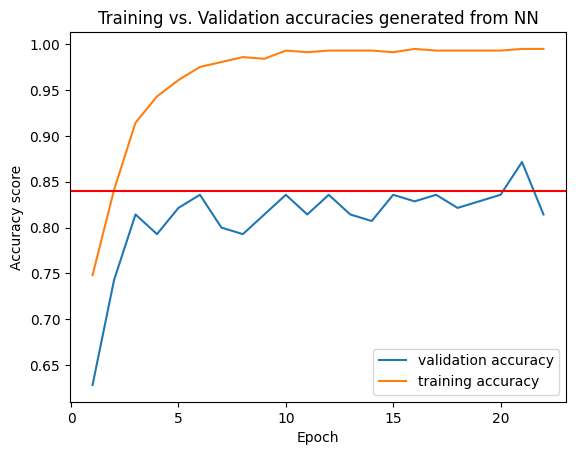

In [ ]:
graph(accuracies, train_accs)

## Latent Space

### nn.Module

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from random import sample
from sklearn.model_selection import train_test_split
import torch.optim as optim

from torch.utils.data import DataLoader

In [ ]:
# build the autoencoder model

# 765 is the feature of X data (both train and test)
input_shape = (765, )
# define the feature number of latent space
latent_dim = 48
dropout_rate = 0.2

# construct autoencoder with L1 regularization
class autoencoderl1(nn.Module):
    def __init__(self):
        super(autoencoderl1, self).__init__()
        
    #Encoder NN
        self.encoder = nn.Sequential(
            nn.Linear(input_shape[0], 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(64, latent_dim),
        )
    
    #Decoder NN
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, input_shape[0]),
            nn.Sigmoid()
        )
    
    #L1 regularization
        self.reg = nn.L1Loss(reduction='sum')
    
    def forward(self, X):
        #X = torch.from_numpy(X)
        X = torch.clone(X)
        #X = X.float()
        X = self.encoder(X)
        X = self.decoder(X)
        return X

In [ ]:
from sklearn.metrics import accuracy_score
from copy import deepcopy

# define train model
def train(model, X_train, X_test, batch_size=16, epochs = 15, lr=1e-4, l1_lambda = 1e-7):
    
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=False)
    #testing_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)
    best_mse = 100
    best_model = None
    
    loss_mse = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    #accuracies = []
    
    for epoch in range(epochs):
        #X_train only has X but not y and loaded in train_loader
        loss = 0
        l1_loss = 0
        for data in iter(train_loader):
            data = data.float()
            
            logits = model.forward(data)
            #print(logits.dtype)
            loss = loss_mse(logits, data)

            # this is for L1 regulate hyperparameters
            # for param in model.parameters():
            #     param.data = param.data.float()

            #     #l1_reg += torch.norm(param, 1)  # In PyTorch, torch.norm(param, 2) computes the L2-norm of the tensor param.
            
            #This is for L1 regulate latent space
            l1_regularization = l1_lambda * torch.mean(torch.abs(logits)) 
            l1_loss += l1_regularization
            loss += l1_regularization
            
            loss = loss.float()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #calcualte train loss after optimization
        # train_loss = loss
        # train_losses.append(float(train_loss))
        # l1_loss = loss/len(train_loader)

        X_train = torch.tensor(X_train).float()
        train_label = model.forward(X_train)
        train_loss = loss_mse(train_label, X_train)
        # l1_reg = 0
        # for param in model.parameters():
        #     param.data = param.data.float()
        #     l1_reg += torch.norm(param, 1)  # In PyTorch, torch.norm(param, 2) computes the L2-norm of the tensor param
        # train_loss += l1_lambda * l1_reg
        train_losses.append(train_loss.detach().numpy())
        
        #calcualte test loss
        X_test = torch.tensor(X_test).float()

        #print(X_test)
        testing_latent = model.forward(X_test)
        #print(testing_label, y_test)
        test_loss = loss_mse(testing_latent, X_test)
        # l1_loss_test = l1_lambda*torch.mean(torch.abs(testing_latent)) 
        # test_loss += l1_loss_test
        test_losses.append(test_loss.detach().numpy())

        if test_loss < best_mse:
            best_mse = test_loss
            best_model = deepcopy(model)
        if test_loss > best_mse+0.1:
            print("stop early!")
            break
        
        print(f"Epoch {epoch + 1}:\ttrain loss {train_loss}")
        print("train loss from l1:", l1_loss)
        print(f"Epoch {epoch + 1}:\ttest loss {test_loss}")
       
    print(f"Resetting model... Smallest test loss:\t{best_mse}")
    model.load_state_dict(best_model.state_dict())
    torch.save({'model_state_dict_0420': best_model.state_dict(),
                'optimizer_state_dict_0420': optimizer.state_dict()},
                'autoencoder_model_0420.pth')
    return train_losses, test_losses
            

In [ ]:
model = autoencoderl1()
train_losses, test_losses = train(model, X_train, X_test, lr=1e-4, l1_lambda = 1e-4, batch_size=16, epochs=30)

Epoch 1:	train loss 1.1631591320037842
train loss from l1: tensor(0.0015, grad_fn=<AddBackward0>)
Epoch 1:	test loss 1.1459782123565674


<ipython-input-10-404dd392b6a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
<ipython-input-10-404dd392b6a4>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()


Epoch 2:	train loss 1.100735068321228
train loss from l1: tensor(0.0012, grad_fn=<AddBackward0>)
Epoch 2:	test loss 1.085760235786438
Epoch 3:	train loss 1.0643134117126465
train loss from l1: tensor(0.0009, grad_fn=<AddBackward0>)
Epoch 3:	test loss 1.0504032373428345
Epoch 4:	train loss 1.0453978776931763
train loss from l1: tensor(0.0007, grad_fn=<AddBackward0>)
Epoch 4:	test loss 1.0344843864440918
Epoch 5:	train loss 1.0335396528244019
train loss from l1: tensor(0.0006, grad_fn=<AddBackward0>)
Epoch 5:	test loss 1.0227010250091553
Epoch 6:	train loss 1.0263851881027222
train loss from l1: tensor(0.0005, grad_fn=<AddBackward0>)
Epoch 6:	test loss 1.0158979892730713
Epoch 7:	train loss 1.02149498462677
train loss from l1: tensor(0.0004, grad_fn=<AddBackward0>)
Epoch 7:	test loss 1.0118730068206787
Epoch 8:	train loss 1.0176944732666016
train loss from l1: tensor(0.0004, grad_fn=<AddBackward0>)
Epoch 8:	test loss 1.0080724954605103
Epoch 9:	train loss 1.0150587558746338
train loss fr

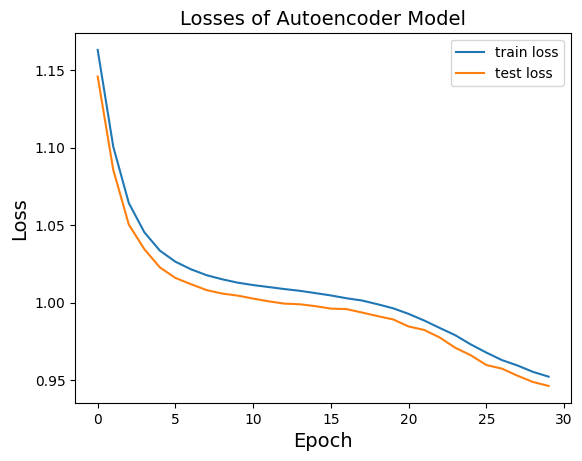

In [ ]:

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("Losses of Autoencoder Model", fontsize=14)
plt.legend();

In [ ]:
# use the same architecture to train all data
model_all = autoencoderl1()
train_losses_all, test_losses_all = train(model_all, X, X_test, lr=1e-4, l1_lambda = 1e-4, batch_size=16, epochs=30)

Epoch 1:	train loss 1.1409293413162231
train loss from l1: tensor(0.0019, grad_fn=<AddBackward0>)
Epoch 1:	test loss 1.1279853582382202


<ipython-input-10-404dd392b6a4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
<ipython-input-10-404dd392b6a4>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()


Epoch 2:	train loss 1.077040433883667
train loss from l1: tensor(0.0013, grad_fn=<AddBackward0>)
Epoch 2:	test loss 1.064601182937622
Epoch 3:	train loss 1.0471093654632568
train loss from l1: tensor(0.0010, grad_fn=<AddBackward0>)
Epoch 3:	test loss 1.0366307497024536
Epoch 4:	train loss 1.0315561294555664
train loss from l1: tensor(0.0007, grad_fn=<AddBackward0>)
Epoch 4:	test loss 1.022530198097229
Epoch 5:	train loss 1.0230271816253662
train loss from l1: tensor(0.0006, grad_fn=<AddBackward0>)
Epoch 5:	test loss 1.0133318901062012
Epoch 6:	train loss 1.0181677341461182
train loss from l1: tensor(0.0005, grad_fn=<AddBackward0>)
Epoch 6:	test loss 1.0081883668899536
Epoch 7:	train loss 1.0138275623321533
train loss from l1: tensor(0.0005, grad_fn=<AddBackward0>)
Epoch 7:	test loss 1.0057708024978638
Epoch 8:	train loss 1.0114822387695312
train loss from l1: tensor(0.0004, grad_fn=<AddBackward0>)
Epoch 8:	test loss 1.0020334720611572
Epoch 9:	train loss 1.0093449354171753
train loss f

### obtain latent space for X_train and X_test

In [ ]:
### obtain encoder latent space
latent_model = model_all
X_train_tensor = torch.tensor(X_train).float()
latent_train_repre = latent_model.encoder(X_train_tensor)
latent_train_array = latent_train_repre.detach().numpy()

X_test_tensor = torch.tensor(X_test).float()
latent_test_repre = latent_model.encoder(X_test_tensor)
latent_test_array = latent_test_repre.detach().numpy()

## Random Forest on Latent Space

In [ ]:
# Using corss_val_score to find the best numbers of tree
rfc = RandomForestClassifier()
n_estimators_range = np.arange(10,200,10)

rfc_mean_score = []
rfc_std_score = [] # in case the std is too large

for n_tree in n_estimators_range:
  rfc = RandomForestClassifier(n_tree)
  score = cross_val_score(rfc, latent_train_array, y_train_back, cv=5, scoring='accuracy')
  mean, std = np.mean(score), np.std(score)
  rfc_mean_score.append(mean)
  rfc_std_score.append(std)

best_n_estimators = n_estimators_range[np.argmax(rfc_mean_score)]
score_of_best = rfc_mean_score[np.argmax(rfc_mean_score)]
std_of_best = rfc_std_score[np.argmax(rfc_mean_score)]
print(f"Best number of trees (n_estimators): {best_n_estimators} with the mean score of {score_of_best} and std of: {std_of_best}")

Best number of trees (n_estimators): 140 with the mean score of 0.7303571428571429 and std of: 0.042030722485499356


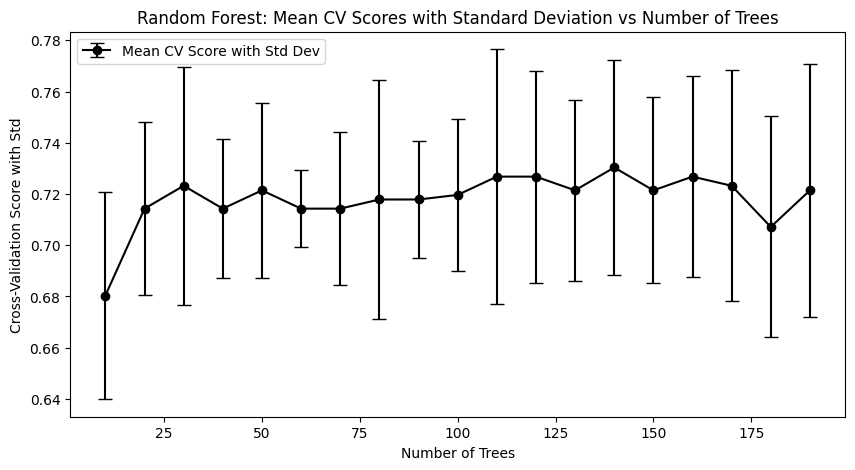

In [ ]:
# plot the mean and std
plt.figure(figsize=(10,5))
plt.errorbar(n_estimators_range, rfc_mean_score, yerr=rfc_std_score, fmt='-o',
             color='black', capsize=5, label='Mean CV Score with Std Dev')
plt.xlabel("Number of Trees")
plt.ylabel("Cross-Validation Score with Std")
plt.legend()
plt.title("Random Forest: Mean CV Scores with Standard Deviation vs Number of Trees")
plt.show()

In [ ]:
# obtain accuracy of test set using training rfc
rfc = RandomForestClassifier(best_n_estimators)
rfc.fit(latent_train_array, y_train_back)
pred_test = rfc.predict(latent_test_array)
la_accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy is ", la_accuracy)
print(classification_report(pred_test, y_test_back))

accuracy is  0.6785714285714286
              precision    recall  f1-score   support

           0       0.83      0.74      0.78        34
           1       0.86      0.88      0.87        49
           2       0.50      0.43      0.46         7
           3       0.20      0.13      0.16        15
           4       0.93      0.88      0.90        16
           5       0.36      0.38      0.37        13
           6       0.00      0.00      0.00         0
           7       0.11      0.25      0.15         4
           8       0.00      0.00      0.00         0
           9       0.67      1.00      0.80         2

    accuracy                           0.68       140
   macro avg       0.45      0.47      0.45       140
weighted avg       0.70      0.68      0.69       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# using grid search
param_grid = {'n_estimators': [50, 75, 100, 125, 150],
    'max_depth': [None,10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],}
# initialize another rfc model for grid search
rfc_grid_la = RandomForestClassifier()
# initialize grid seach for rfc
grid_search_rfc_la = GridSearchCV(estimator=rfc_grid_la, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
grid_search_rfc_la.fit(X_train, y_train_back)
best_params_la = grid_search_rfc_la.best_params_
print(f"Best hyperparameters: {best_params_la}")
best_rfc_la = grid_search_rfc_la.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# obtain accuracy of test set using training rfc
best_rfc_la.fit(latent_train_array, y_train_back)
pred_test = best_rfc_la.predict(latent_test_array)

accuracy_la = accuracy_score(pred_test, y_test_back)
print("accuracy is ", accuracy_la)
print(classification_report(pred_test, y_test_back))

accuracy is  0.6928571428571428
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        33
           1       0.84      0.89      0.87        47
           2       0.50      0.43      0.46         7
           3       0.60      0.33      0.43        18
           4       0.93      0.78      0.85        18
           5       0.36      0.42      0.38        12
           6       0.00      0.00      0.00         0
           7       0.11      0.25      0.15         4
           8       0.00      0.00      0.00         0
           9       0.33      1.00      0.50         1

    accuracy                           0.69       140
   macro avg       0.45      0.49      0.44       140
weighted avg       0.74      0.69      0.71       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree on Latent Space

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# cross_val_score
max_depth_range = np.arange(1,20,2)

dt_mean_score = []
dt_std_score = [] # in case the std is too large

for depth in max_depth_range:
  dt = DecisionTreeClassifier(max_depth=depth)
  score = cross_val_score(dt, latent_train_array, y_train_back, cv=5, scoring='accuracy', error_score='raise')
  mean, std = np.mean(score), np.std(score)
  dt_mean_score.append(mean)
  dt_std_score.append(std)

In [ ]:
best_depth = max_depth_range[np.argmax(dt_mean_score)]
score_of_best = dt_mean_score[np.argmax(dt_mean_score)]
std_of_best = dt_std_score[np.argmax(dt_mean_score)]
print(f"Best max depth: {best_depth} with the mean score of {score_of_best} and std of: {std_of_best}")

Best max depth: 5 with the mean score of 0.6607142857142857 and std of: 0.0258774584753383


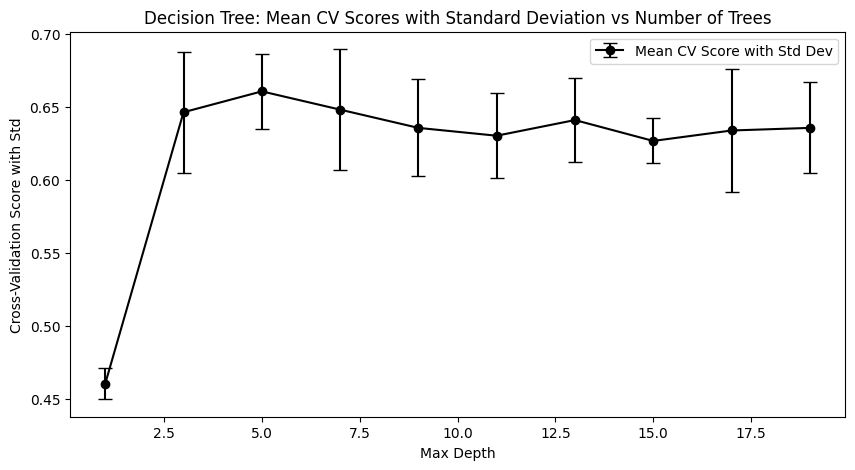

In [ ]:
# plot the mean and std
plt.figure(figsize=(10,5))
plt.errorbar(max_depth_range, dt_mean_score, yerr=dt_std_score, fmt='-o',
             color='black', capsize=5, label='Mean CV Score with Std Dev')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validation Score with Std")
plt.legend()
plt.title("Decision Tree: Mean CV Scores with Standard Deviation vs Number of Trees")
plt.show()

In [ ]:
# obtain accuracy of test set using training rfc
dt = DecisionTreeClassifier(max_depth=best_depth) 
dt.fit(latent_train_array, y_train_back)
pred_test = dt.predict(latent_test_array)
accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy is ", accuracy)
print(classification_report(pred_test, y_test_back))

accuracy is  0.6071428571428571
              precision    recall  f1-score   support

           0       0.80      0.59      0.68        41
           1       0.76      0.86      0.81        44
           2       0.83      0.56      0.67         9
           3       0.80      0.28      0.41        29
           4       0.53      0.89      0.67         9
           5       0.14      0.50      0.22         4
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1

    accuracy                           0.61       140
   macro avg       0.39      0.37      0.35       140
weighted avg       0.73      0.61      0.63       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# using grid search
param_grid = {
    'max_depth': [None,2, 4, 6, 8],
    'min_samples_split': [1, 2, 5, 7,10],
    'min_samples_leaf': [1, 2, 4, 6, 8],}
# initialize another rfc model for grid search
dt_grid_la = DecisionTreeClassifier()
# initialize grid seach for rfc
grid_search_dt_la = GridSearchCV(estimator=dt_grid_la, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
grid_search_dt_la.fit(latent_train_array, y_train_back)
best_params = grid_search_dt_la.best_params_
print(f"Best hyperparameters: {best_params}")
best_dt = grid_search_dt_la.best_estimator_

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best hyperparameters: {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 2}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
125 fits failed out of a total of 625.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _vali

In [ ]:
# obtain accuracy of test set using training dt
best_dt.fit(latent_train_array, y_train_back)
pred_test = best_dt.predict(latent_test_array)
accuracy_dt_la = accuracy_score(pred_test, y_test_back)
print("accuracy of decision tree classifier is ", accuracy_dt_la)
print(classification_report(pred_test, y_test_back))

accuracy of decision tree classifier is  0.5785714285714286
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        27
           1       0.82      0.75      0.78        55
           2       0.50      0.43      0.46         7
           3       0.40      0.31      0.35        13
           4       0.53      0.89      0.67         9
           5       0.21      0.43      0.29         7
           6       0.00      0.00      0.00         3
           7       0.44      0.27      0.33        15
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         4

    accuracy                           0.58       140
   macro avg       0.35      0.37      0.35       140
weighted avg       0.59      0.58      0.58       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## AdaBoost on Latent Space

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# cross_val_score
#dt = DecisionTreeClassifier()
n_estimators_range = np.arange(10,200,10)

clf_mean_score = []
clf_std_score = [] # in case the std is too large

for n in n_estimators_range:
  clf = AdaBoostClassifier(n_estimators=n)
  score = cross_val_score(clf, latent_train_array, y_train_back, cv=5, scoring='accuracy')
  mean, std = np.mean(score), np.std(score)
  clf_mean_score.append(mean)
  clf_std_score.append(std)

In [ ]:
best_n_estimators = n_estimators_range[np.argmax(clf_mean_score)]
score_of_best = clf_mean_score[np.argmax(clf_mean_score)]
std_of_best = clf_std_score[np.argmax(clf_mean_score)]
print(f"Best number of trees (n_estimators): {best_n_estimators} with the mean score of {score_of_best} and std of: {std_of_best}")

Best number of trees (n_estimators): 10 with the mean score of 0.5410714285714285 and std of: 0.06766891186248719


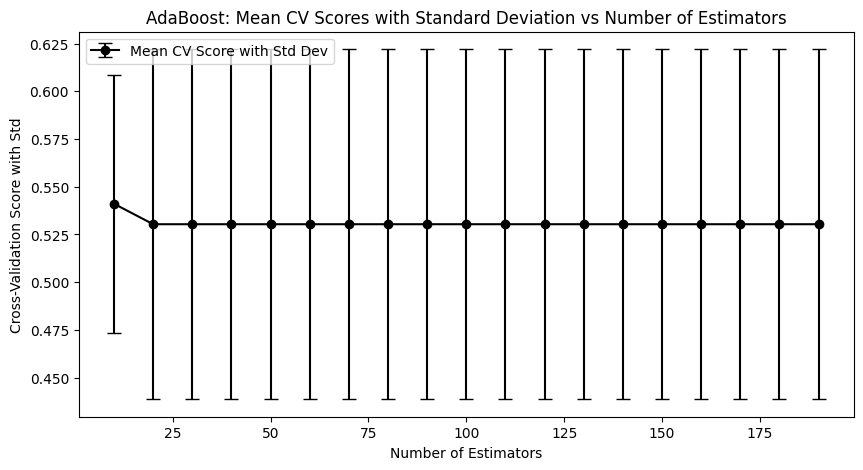

In [ ]:
# plot the mean and std
plt.figure(figsize=(10,5))
plt.errorbar(n_estimators_range, clf_mean_score, yerr=clf_std_score, fmt='-o',
             color='black', capsize=5, label='Mean CV Score with Std Dev')
plt.xlabel("Number of Estimators")
plt.ylabel("Cross-Validation Score with Std")
plt.legend()
plt.title("AdaBoost: Mean CV Scores with Standard Deviation vs Number of Estimators")
plt.show()

In [ ]:
# obtain accuracy of test set using training rfc
clf = DecisionTreeClassifier(max_depth=best_depth) 
clf.fit(latent_train_array, y_train_back)
pred_test = clf.predict(latent_test_array)
accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy is ", accuracy)
print(classification_report(pred_test, y_test_back))

accuracy is  0.6142857142857143
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        40
           1       0.76      0.86      0.81        44
           2       0.83      0.56      0.67         9
           3       0.80      0.28      0.41        29
           4       0.60      0.90      0.72        10
           5       0.14      0.50      0.22         4
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1

    accuracy                           0.61       140
   macro avg       0.39      0.37      0.35       140
weighted avg       0.73      0.61      0.64       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
base_classifier = DecisionTreeClassifier(max_depth=5)
ada_clf = AdaBoostClassifier(base_estimator=base_classifier)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.005, 0.01, 0.1],
    'algorithm': ['SAMME', 'SAMME.R']
}

grid_search_ada_la = GridSearchCV(ada_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
grid_search_ada_la.fit(latent_train_array, y_train_back)
best_ada_params_la = grid_search_ada_la.best_params_
print(f"Best hyperparameters: {best_ada_params_la}")
best_ada_clf_la = grid_search_ada_la.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best hyperparameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}


In [ ]:
# obtain accuracy of test set using training dt
best_ada_clf_la.fit(latent_train_array, y_train_back)
pred_test = best_ada_clf_la.predict(latent_test_array)
accuracy_ada_la = accuracy_score(pred_test, y_test_back)
print("accuracy of AdaBoost classifier is ", accuracy_ada_la)
print(classification_report(pred_test, y_test_back))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


accuracy of AdaBoost classifier is  0.6714285714285714
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        33
           1       0.86      0.88      0.87        49
           2       0.67      0.57      0.62         7
           3       0.40      0.21      0.28        19
           4       0.93      0.78      0.85        18
           5       0.36      0.62      0.45         8
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.67       140
   macro avg       0.40      0.38      0.38       140
weighted avg       0.72      0.67      0.69       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Support Vector Machine (SVM) on Latent Space


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto',1, 0.1, 0.01, 0.001]
}

grid_search_svc = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svc.fit(latent_train_array, y_train_back)

best_svc_params = grid_search_svc.best_params_
print(f"Best hyperparameters: {best_svc_params}")
best_svc = grid_search_svc.best_estimator_


Best hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
# obtain accuracy of test set using training dt
best_svc.fit(latent_train_array, y_train_back)
pred_test = best_svc.predict(latent_test_array)
accuracy = accuracy_score(pred_test, y_test_back)
print("accuracy of decision tree classifier is ", accuracy)
print(classification_report(pred_test, y_test_back))

accuracy of decision tree classifier is  0.6785714285714286
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.86      0.86      0.86        50
           2       0.33      0.25      0.29         8
           3       0.60      0.30      0.40        20
           4       0.93      0.88      0.90        16
           5       0.29      0.31      0.30        13
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.33      1.00      0.50         1

    accuracy                           0.68       140
   macro avg       0.42      0.44      0.41       140
weighted avg       0.74      0.68      0.70       140



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## FFNN on Latent Space

In [ ]:
latent_train_t, y_train_back_t = torch.tensor(latent_train_array).type(torch.float32), torch.tensor(y_train_back).type(torch.long)
latent_test_t, y_test_back_t = torch.tensor(latent_test_array).type(torch.float32), torch.tensor(y_test_back).type(torch.long)

In [ ]:
class My_Network_latent(nn.Module):
    def __init__(self, num_layers, hidden_size):
        super().__init__()
        input_dim = 48
        output_dim = 10
        drop_rate = 0.1
        #mid_dim = int(hidden_size * drop_rate)

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_dim, hidden_size)
        
        self.hidden_layer_list = nn.ModuleList() #generate a list of hidden layer with different weight and bias
        self.batch_norm_list = nn.ModuleList()
        for i in range(num_layers):
          self.hidden_layer_list.append(nn.Linear(hidden_size, hidden_size))
          self.batch_norm_list.append(nn.BatchNorm1d(hidden_size))
        self.batch_norm = nn.BatchNorm1d(hidden_size) #Lu: remember dropout layer don't change the shape of hidden layer
        self.drop_layer = nn.Dropout(drop_rate) # 50% probability 
       
        #self.hidden_layer_mid = nn.Linear(mid_dim, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_dim)
    
    def forward(self, X):
        X = self.input_layer(X)
        
        X = self.batch_norm(X)
        X = F.relu(X)
        for hidden_layer, batch_norm in zip(self.hidden_layer_list, self.batch_norm_list):
          
          X = hidden_layer(X)
          
          X = batch_norm(X)
          X = F.relu(X)
          X = self.drop_layer(X)
        logits = self.output_layer(X) 
        return logits
    def classify(self, X):
        X = torch.clone(X).type(torch.float32)
        logits = self.forward(X) # calculate theta after NN forward (define by my self)
        soft_prob = F.softmax(logits, dim=1)
        labels = torch.argmax(soft_prob, dim=1)
        return labels

In [ ]:
def train_2(model, X_train, y_train, X_val, y_val, epochs=15, batch_size=12, lr=1e-4):
    
    best_acc = -1
    best_model = None
    batches = len(X_train)//batch_size   # using batch_size, determine the number of batches needed

    loss_fn = nn.CrossEntropyLoss()                             # read the write-up for an explanation on CrossEntropyLoss()
    # nn.module.parameter(): w and b
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)     # read the write-up for an explanation on Adam

    losses = []
    train_accs = []
    accuracies = []

    for epoch in range(epochs):
        for i in range(batches):
            X_batch = X_train[i*batch_size : (i+1)*batch_size]
            y_batch = y_train[i*batch_size : (i+1)*batch_size]
            
            logits = model.forward(X_batch)
            
            #prob_soft = F.softmax(logits, dim=1)
            loss = loss_fn(logits, y_batch)

            optimizer.zero_grad()   # erases the gradients from the previous epoch (sets all gradients to 0)
            loss.backward()         # calculates the gradients with respect to every single weight matrix in the model
            optimizer.step()        # takes ONE learning step with the gradients just calculated

        train_label = model.classify(X_train) #Lu: obtain updated theta from backward. don't put this step before loss.backward
        cur_train_accu = sklearn.metrics.accuracy_score(y_train, train_label)

        val_label = model.classify(X_val)
        accuracy = sklearn.metrics.accuracy_score(y_val, val_label)

        losses.append(loss)  #append loss
        train_accs.append(cur_train_accu)
        accuracies.append(accuracy)

        if accuracy > best_acc:     # implement the fall-back technique mentioned in the description
            best_acc = accuracy
            #deepcopy: has a new address for the copy of this datapoint 
            best_model = deepcopy(model)
        if accuracy < best_acc - 0.1:
            print("stopping early!")
            break

        print(f"Epoch {epoch + 1}:\tloss {np.round(loss.detach().cpu().numpy().item(), 4)}\t& accuracy {np.round(accuracy, 4)}")
    print(f"Resetting model... Best validation accuracy:\t{np.round(best_acc, 4)}")
    model.load_state_dict(best_model.state_dict())
    return losses, accuracies, train_accs

In [ ]:
my_model = My_Network_latent(2, 48)
losses, accuracies, train_accs = train_2(my_model, latent_train_t, y_train_back_t, latent_test_t, y_test_back_t, epochs=50)

Epoch 1:	loss 2.5525	& accuracy 0.1
Epoch 2:	loss 2.283	& accuracy 0.2714
Epoch 3:	loss 2.1806	& accuracy 0.4643
Epoch 4:	loss 2.1294	& accuracy 0.6071
Epoch 5:	loss 2.1336	& accuracy 0.6571
Epoch 6:	loss 2.1155	& accuracy 0.6643
Epoch 7:	loss 1.9571	& accuracy 0.6786
Epoch 8:	loss 1.8879	& accuracy 0.6929
Epoch 9:	loss 1.9003	& accuracy 0.7071
Epoch 10:	loss 1.7152	& accuracy 0.6857
Epoch 11:	loss 1.8327	& accuracy 0.6786
Epoch 12:	loss 1.6422	& accuracy 0.6929
Epoch 13:	loss 1.6056	& accuracy 0.7
Epoch 14:	loss 1.5388	& accuracy 0.6571
Epoch 15:	loss 1.4971	& accuracy 0.6786
Epoch 16:	loss 1.4574	& accuracy 0.6786
Epoch 17:	loss 1.428	& accuracy 0.7143
Epoch 18:	loss 1.505	& accuracy 0.7214
Epoch 19:	loss 1.529	& accuracy 0.6857
Epoch 20:	loss 1.3941	& accuracy 0.7143
Epoch 21:	loss 1.343	& accuracy 0.7214
Epoch 22:	loss 1.3359	& accuracy 0.7
Epoch 23:	loss 1.3456	& accuracy 0.7071
Epoch 24:	loss 1.3516	& accuracy 0.7143
Epoch 25:	loss 1.351	& accuracy 0.7071
Epoch 26:	loss 1.27	& ac

In [ ]:
from numpy.core.function_base import linspace
import math
def graph(accuracies, training_accs):
    epoch = range(1, len(accuracies)+1)
    plt.plot(epoch, accuracies, label = 'validation accuracy')
    plt.plot(epoch, training_accs, label = 'training accuracy')
    plt.legend()
    plt.axhline(y = 0.7, color='r')
    #new_list = range(math.floor(min(epoch)), math.ceil(max(epoch))+1)
    #plt.xticks(new_list)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy score')
    plt.title('Training vs. Validation accuracies generated from NN')

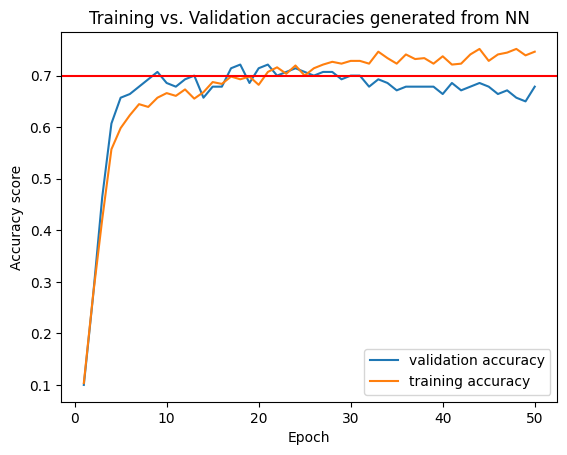

In [ ]:
graph(accuracies, train_accs)

## Compare the classification effects between raw data and latent space

In [ ]:
data = {
    'Model': ['RandomForest', 'DecisionTree', 'AdaBoost', 'SVM', 'FFNN', 'RandomForest', 'DecisionTree', 'AdaBoost', 'SVM', 'FFNN'],
    'Accuracy': [0.8214285714285714, 0.7357142857142858, 0.7857142857142857, 0.8714, 0.8428571428571429,
                 0.6928571428571428, 0.5785714285714286, 0.6714285714285714, 0.6785714285714286, 0.7214],
    'Classfied Data': ['Raw', 'Raw', 'Raw', 'Raw', 'Raw', 'Latent Space', 'Latent Space', 'Latent Space', 'Latent Space', 'Latent Space']
}

In [ ]:
df = pd.DataFrame(data)
df

,Model,Accuracy,Classfied Data
0,RandomForest,0.821429,Raw
1,DecisionTree,0.735714,Raw
2,AdaBoost,0.785714,Raw
3,SVM,0.871400,Raw
4,FFNN,0.842857,Raw
5,RandomForest,0.692857,Latent Space
6,DecisionTree,0.578571,Latent Space
7,AdaBoost,0.671429,Latent Space
8,SVM,0.678571,Latent Space
9,FFNN,0.721400,Latent Space


Text(0.5, 1.0, 'Accuracy of Classification Models on Raw Data and AutoEncoder Latent Space Representative')

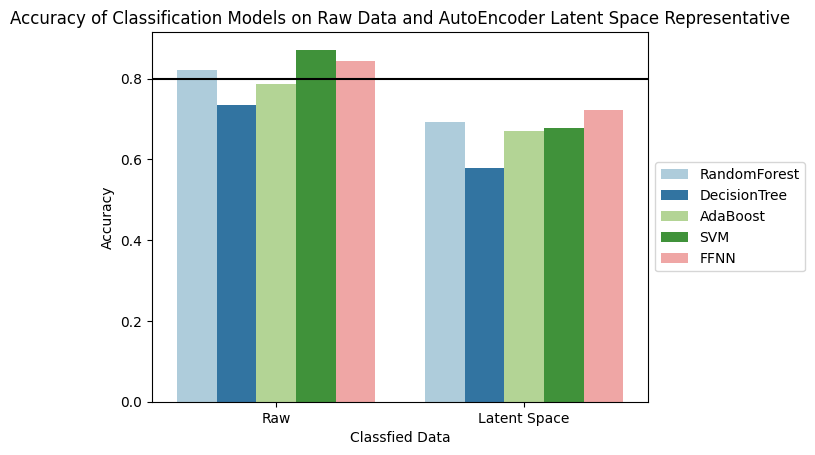

In [ ]:
sns.barplot(data = df, x='Classfied Data', y='Accuracy', hue='Model', palette='Paired')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y = 0.8, color='black')
plt.title ("Accuracy of Classification Models on Raw Data and AutoEncoder Latent Space Representative")